### testing the importance of distance on instruction priority

In [1]:
%pip install huggingface_hub
%pip install python-dotenv
%pip install huggingface
%pip install datasets
%pip install transformers
%pip install matplotlib
%pip install accelerate


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To updat

In [2]:
import os
from dotenv import load_dotenv
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["DATASETS_DISABLE_PROGRESS_BAR"] = "1"

load_dotenv()
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")

In [3]:
!hf auth login --token {huggingface_token}

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.


Token is valid (permission: fineGrained).
The token `a3` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `a3`


In [4]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import random
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [5]:
#load wiki
ds = load_dataset("wikitext", "wikitext-2-raw-v1")

In [6]:
print(type(ds))
print(ds)

<class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [7]:
print(ds["train"][7])

{'text': ' = = Gameplay = = \n'}


In [8]:
def keep_row(example):
    text = example['text']
    if not text:
        return False
    if text == "\n":
        return False
    # if text.startswith("="):
    #     return False
    return True

In [9]:
filtered_wiki = ds.filter(keep_row)

Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [10]:
model_name = "google/gemma-2-9b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
### tokenize dataset
full_text = "\n".join([line for line in filtered_wiki["train"]["text"]])
all_tokens = tokenizer.encode(full_text, add_special_tokens = False)

In [12]:
def get_r_wiki_slice(n_tokens):
    start_idx = random.randint(0, len(all_tokens) - n_tokens - 1)
    return all_tokens[start_idx : start_idx + n_tokens]

In [13]:
# system_prompt = "Your goal is to respond to the user's request while making sure his instructions are fully satistfied. An instruction will appear in the form 'Instruction: <INSTRUCTION>.'\n"
system_prompt = ""
end_question = "\nNow, provide your response based on the previous instructions. \n"

instruction_set = {
    "language": ["Respond in French.", "Respond in German."],
    "first_word": ["Begin your response with the word 'CHERRY'.", "Begin your response with the word 'APPLE'."],
}


In [14]:
def find_token_span(target_ids, full_ids):
    n = len(target_ids)
    for i in range(len(full_ids) - n + 1):
        if full_ids[i : i + n] == target_ids:
            return i, i + n
    return None, None

In [15]:
def construct_single_instr_prompt(instr_text, pos_pct, total_length=2048):
    formatted_instr = f"\n\nInstruction: {instr_text}\n\n"
    
    dummy_messages = [{"role": "user", "content": "DUMMY"}]
    dummy_ids = tokenizer.apply_chat_template(dummy_messages, tokenize=True, add_generation_prompt=True)
    template_overhead = len(dummy_ids) - len(tokenizer.encode("DUMMY", add_special_tokens=False))
    
    instr_tokens = tokenizer.encode(formatted_instr, add_special_tokens=False)
    sys_tokens = tokenizer.encode(system_prompt, add_special_tokens=False)
    end_tokens = tokenizer.encode(end_question, add_special_tokens=False)
    
    fixed_parts_len = len(sys_tokens) + len(instr_tokens) + len(end_tokens) + template_overhead
    filler_budget = total_length - fixed_parts_len
    
    if filler_budget < 0:
        raise ValueError(f"Instructions too long! Overhead is {fixed_parts_len}")

    filler_tokens = get_r_wiki_slice(filler_budget)
    split_idx = int(pos_pct * filler_budget)
    
    user_content = (
        system_prompt + 
        tokenizer.decode(filler_tokens[:split_idx]) + 
        formatted_instr + 
        tokenizer.decode(filler_tokens[split_idx:]) + 
        end_question
    )
    
    messages = [{"role": "user", "content": user_content}]
    input_ids = tokenizer.apply_chat_template(
        messages, 
        tokenize=True, 
        add_generation_prompt=True, 
        return_tensors="pt"
    )

    if input_ids.shape[1] != total_length:
        diff = input_ids.shape[1] - total_length
        if diff > 0:

            input_ids = torch.cat([input_ids[:, :10], input_ids[:, 10+diff:]], dim=1)
        else:
            padding = torch.full((1, abs(diff)), tokenizer.pad_token_id).to(input_ids.device)
            input_ids = torch.cat([input_ids[:, :10], padding, input_ids[:, 10:]], dim=1)

    return input_ids, None

In [16]:
test_ids, _ = construct_single_instr_prompt("Begin with CHERRY", 0.5, 1024)
print(f"Total length: {test_ids.shape[1]}")
print(f"End of prompt tokens: {test_ids[0, -10:].tolist()}")
print(f"End of prompt decoded: '{tokenizer.decode(test_ids[0, -15:])}'")

Total length: 1024
End of prompt tokens: [611, 573, 4509, 12027, 235265, 107, 108, 106, 2516, 108]
End of prompt decoded: ', provide your response based on the previous instructions.<end_of_turn>
<start_of_turn>model
'


In [15]:
cherry_ids = [
    tokenizer.encode(" CHERRY", add_special_tokens=False)[0],
    tokenizer.encode("CHERRY\n", add_special_tokens=False)[0],
    tokenizer.encode("CHERRY ", add_special_tokens=False)[0],
    tokenizer.encode("CHERRY", add_special_tokens=False)[0],
    tokenizer.encode("\nCHERRY", add_special_tokens=False)[0],
]

apple_ids = [
    tokenizer.encode(" APPLE", add_special_tokens=False)[0],
    tokenizer.encode("APPLE\n", add_special_tokens=False)[0],
    tokenizer.encode("APPLE ", add_special_tokens=False)[0],
    tokenizer.encode("APPLE", add_special_tokens=False)[0],
    tokenizer.encode("\nAPPLE", add_special_tokens=False)[0],
]

In [23]:
def batched_position_sweep(model, instr_text, total_length, samples_per_pos=100, batch_size=2):
    device = next(model.parameters()).device
    pcts = np.linspace(0.0, 1.0, 21)
    target_token_id = tokenizer.encode(" CHERRY", add_special_tokens=False)[0]
    
    results = {round(pct, 2): {"logits": [], "is_correct": []} for pct in pcts}
    # This will now store a LIST of completions for each position
    decoded_completions = {round(pct, 2): [] for pct in pcts}
    
    model.eval()
    for pct in pcts:
        pct_key = round(pct, 2)
        print(f"Processing Position: {pct_key:.2f}")
        
        num_batches = (samples_per_pos + batch_size - 1) // batch_size
        
        # Determine which specific global indices we want to decode (5%)
        num_to_decode = math.ceil(0.05 * samples_per_pos)
        decode_indices = set(random.sample(range(samples_per_pos), num_to_decode))
        
        global_idx = 0 

        for b in tqdm(range(num_batches)):
            batch_list = []
            for _ in range(batch_size):
                if len(batch_list) + b*batch_size < samples_per_pos: # Handle final uneven batch
                    ids, _ = construct_single_instr_prompt(instr_text, pct, total_length)
                    batch_list.append(ids)
            
            batch_tensor = torch.cat(batch_list, dim=0).to(device)
            
            with torch.no_grad():
                outputs = model(batch_tensor)
                last_token_logits = outputs.logits[:, -1, :] 
            
            # Logit/Accuracy Data
            cherry_logits = last_token_logits[:, target_token_id].cpu().tolist()
            results[pct_key]["logits"].extend(cherry_logits)
            
            predictions = torch.argmax(last_token_logits, dim=-1)
            correct_mask = [p.item() in cherry_ids for p in predictions]
            results[pct_key]["is_correct"].extend(correct_mask)
            

            # decoded_batch = tokenizer.batch_decode(gen_ids[:, total_length:], skip_special_tokens=True)
            # is_correct = ["CHERRY" in resp.upper() for resp in decoded_batch]
            # results[pct_key]["is_correct"].extend(is_correct)

            # --- THE SANITY CHECK DECODE ---
            # We check each item in the current batch to see if its global index is in our 5% set
            for i in range(len(batch_list)):
                if global_idx in decode_indices:
                    with torch.no_grad():
                        # Generate for just this one sequence
                        gen_ids = model.generate(
                            batch_tensor[i:i+1], 
                            max_new_tokens=15, # Increased to see the full context of the failure
                            do_sample=False,
                            pad_token_id=tokenizer.eos_token_id
                        )
                        # Extract and store completion only
                        completion = tokenizer.decode(gen_ids[0, total_length:], skip_special_tokens=True)
                        decoded_completions[pct_key].append(completion)
                
                global_idx += 1
            
            del outputs
            torch.cuda.empty_cache()
            
    return results, decoded_completions

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="eager" 
)

`torch_dtype` is deprecated! Use `dtype` instead!


In [28]:
def plot_dual_results(results, word):
    x = sorted(results.keys())

    token_id = tokenizer.encode(word, add_special_tokens=False)[0]
    # Prepare Data
    logit_means = [np.mean(results[pct][f"logits_{token_id}"]) for pct in x]
    logit_stds = [np.std(results[pct][f"logits_{token_id}"]) for pct in x]
    accuracy = [np.mean(results[pct][f"is_correct_{token_id}"]) for pct in x]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Logits
    color = 'tab:blue'
    ax1.set_xlabel('Position (0.0=Start, 1.0=End)')
    ax1.set_ylabel(f'Logit Magnitude ({word})', color=color)
    ax1.errorbar(x, logit_means, yerr=logit_stds, fmt='-o', color=color, label='Logit')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot Accuracy on second axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel(f'Accuracy (Was {word} Top-1)', color=color)
    ax2.plot(x, accuracy, '-s', color=color, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(-0.1, 1.1) # Accuracy is 0 to 1

    plt.title(f"Instruction Salience:")
    fig.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

Processing Position: 0.00


100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


Processing Position: 0.05


100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


Processing Position: 0.10


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Processing Position: 0.15


100%|██████████| 10/10 [00:38<00:00,  3.83s/it]


Processing Position: 0.20


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Processing Position: 0.25


100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


Processing Position: 0.30


100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


Processing Position: 0.35


100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


Processing Position: 0.40


100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


Processing Position: 0.45


100%|██████████| 10/10 [00:38<00:00,  3.83s/it]


Processing Position: 0.50


100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


Processing Position: 0.55


100%|██████████| 10/10 [00:38<00:00,  3.85s/it]


Processing Position: 0.60


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Processing Position: 0.65


100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


Processing Position: 0.70


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Processing Position: 0.75


100%|██████████| 10/10 [00:37<00:00,  3.80s/it]


Processing Position: 0.80


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Processing Position: 0.85


100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


Processing Position: 0.90


100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


Processing Position: 0.95


100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


Processing Position: 1.00


100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


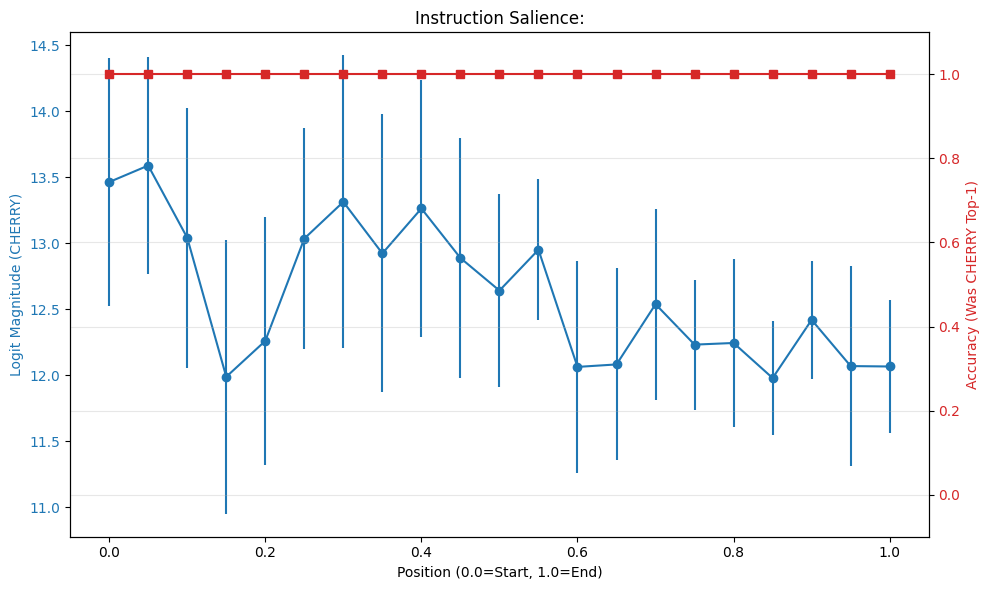

In [ ]:
sweep_data, examples = batched_position_sweep(model, instruction_set["first_word"][0], total_length=6144, samples_per_pos=20)
plot_dual_results(sweep_data)

In [ ]:
print(examples)

In [23]:
def construct_multi_instr_prompt(instr_texts, pos_pct, total_length=2048):
    formatted_instr1 = f"\n\nInstruction: {instr_texts[0]}\n\n"
    formatted_instr2 = f"\n\nInstruction: {instr_texts[1]}\n\n"
    dummy_messages = [{"role": "user", "content": "DUMMY"}]
    dummy_ids = tokenizer.apply_chat_template(dummy_messages, tokenize=True, add_generation_prompt=True)
    template_overhead = len(dummy_ids) - len(tokenizer.encode("DUMMY", add_special_tokens=False))
    
    instr1_tokens = tokenizer.encode(formatted_instr1, add_special_tokens=False)
    instr2_tokens = tokenizer.encode(formatted_instr2, add_special_tokens=False)
    sys_tokens = tokenizer.encode(system_prompt, add_special_tokens=False)
    end_tokens = tokenizer.encode(end_question, add_special_tokens=False)
    
    fixed_parts_len = len(sys_tokens) + len(instr1_tokens) + len(instr2_tokens) + len(end_tokens) + template_overhead
    filler_budget = total_length - fixed_parts_len
    
    if filler_budget < 0:
        raise ValueError(f"Instructions too long! Overhead is {fixed_parts_len}")

    filler_tokens = get_r_wiki_slice(filler_budget)
    split_idx = int(pos_pct * filler_budget)
    
    user_content = (
        system_prompt + 
        formatted_instr1 + 
        tokenizer.decode(filler_tokens[:split_idx]) + 
        formatted_instr2 + 
        tokenizer.decode(filler_tokens[split_idx:]) + 
        end_question
    )
    
    messages = [{"role": "user", "content": user_content}]
    input_ids = tokenizer.apply_chat_template(
        messages, 
        tokenize=True, 
        add_generation_prompt=True, 
        return_tensors="pt"
    )

    if input_ids.shape[1] != total_length:
        diff = input_ids.shape[1] - total_length
        if diff > 0:

            input_ids = torch.cat([input_ids[:, :10], input_ids[:, 10+diff:]], dim=1)
        else:
            padding = torch.full((1, abs(diff)), tokenizer.pad_token_id).to(input_ids.device)
            input_ids = torch.cat([input_ids[:, :10], padding, input_ids[:, 10:]], dim=1)

    return input_ids, None

In [ ]:
def batched_position_sweep_multiple(model, instr_texts, total_length, samples_per_pos=100, batch_size=2):
    device = next(model.parameters()).device
    pcts = np.linspace(0.0, 1.0, 21)
    cherry_token_id = tokenizer.encode(" CHERRY", add_special_tokens=False)[0]
    apple_token_id = tokenizer.encode( " APPLE", add_special_tokens=False)[0]
    results = {round(pct, 2): {f"logits_{cherry_token_id}": [], f"is_correct_{cherry_token_id}": [], f"logits_{apple_token_id}": [], f"is_correct_{apple_token_id}": []} for pct in pcts}
    
    decoded_completions = {round(pct, 2): [] for pct in pcts}
    
    model.eval()
    for pct in pcts:
        pct_key = round(pct, 2)
        print(f"Processing Position: {pct_key:.2f}")
        
        num_batches = (samples_per_pos + batch_size - 1) // batch_size
        
        # Determine which specific global indices we want to decode (5%)
        num_to_decode = math.ceil(0.05 * samples_per_pos)
        decode_indices = set(random.sample(range(samples_per_pos), num_to_decode))
        
        global_idx = 0 

        for b in tqdm(range(num_batches)):
            batch_list = []
            for _ in range(batch_size):
                if len(batch_list) + b*batch_size < samples_per_pos: # Handle final uneven batch
                    ids, _ = construct_multi_instr_prompt(instr_texts, pct, total_length)
                    batch_list.append(ids)
            
            batch_tensor = torch.cat(batch_list, dim=0).to(device)
            
            with torch.no_grad():
                outputs = model(batch_tensor)
                last_token_logits = outputs.logits[:, -1, :] 
            
            # Logit/Accuracy Data
            cherry_logits = last_token_logits[:, cherry_token_id].cpu().tolist()
            apple_logits = last_token_logits[:, apple_token_id].cpu().tolist()
            results[pct_key][f"logits_{cherry_token_id}"].extend(cherry_logits)
            results[pct_key][f"logits_{apple_token_id}"].extend(apple_logits)
            
            
            predictions = torch.argmax(last_token_logits, dim=-1)
            correct_masks = {f"{cherry_token_id}": [p.item() in cherry_ids for p in predictions],
                             f"{apple_token_id}": [p.item() in apple_ids for p in predictions]}
            results[pct_key][f"is_correct_{cherry_token_id}"].extend(correct_masks[f"{cherry_token_id}"])
            results[pct_key][f"is_correct_{apple_token_id}"].extend(correct_masks[f"{apple_token_id}"])
            

            # decoded_batch = tokenizer.batch_decode(gen_ids[:, total_length:], skip_special_tokens=True)
            # is_correct = ["CHERRY" in resp.upper() for resp in decoded_batch]
            # results[pct_key]["is_correct"].extend(is_correct)

            # --- THE SANITY CHECK DECODE ---
            # We check each item in the current batch to see if its global index is in our 5% set
            for i in range(len(batch_list)):
                if global_idx in decode_indices:
                    with torch.no_grad():
                        # Generate for just this one sequence
                        gen_ids = model.generate(
                            batch_tensor[i:i+1], 
                            max_new_tokens=15, # Increased to see the full context of the failure
                            do_sample=False,
                            pad_token_id=tokenizer.eos_token_id
                        )
                        # Extract and store completion only
                        completion = tokenizer.decode(gen_ids[0, total_length:], skip_special_tokens=True)
                        decoded_completions[pct_key].append(completion)
                
                global_idx += 1
            
            del outputs
            torch.cuda.empty_cache()
            
    return results, decoded_completions

In [33]:
sweep_data, examples = batched_position_sweep_multiple(model, instruction_set["first_word"], total_length=6144, samples_per_pos=20)


Processing Position: 0.00


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


Processing Position: 0.05


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


Processing Position: 0.10


100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


Processing Position: 0.15


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.20


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.25


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.30


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.35


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.40


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.45


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.50


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.55


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.60


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.65


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.70


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.75


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.80


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.85


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.90


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 0.95


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Processing Position: 1.00


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


{0.0: {'logits_4029': [15.6875, 15.0, 15.8125, 15.375, 16.25, 13.9375, 14.875, 16.875, 16.25, 16.625, 16.375, 16.125, 14.4375, 17.0, 14.875, 16.5, 15.375, 14.9375, 16.125, 15.5625], 'is_correct_4029': [True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True], 'logits_109248': [20.125, 20.25, 18.875, 19.375, 21.0, 19.0, 20.625, 21.0, 19.625, 20.0, 20.875, 20.0, 21.375, 21.375, 16.625, 20.875, 19.0, 19.125, 19.75, 21.5], 'is_correct_109248': [False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False]}, 0.05: {'logits_4029': [15.9375, 15.125, 16.5, 15.375, 15.25, 15.0, 16.5, 14.4375, 16.375, 16.25, 16.125, 12.1875, 15.5625, 15.375, 16.0, 16.625, 15.5625, 14.75, 14.5, 14.75], 'is_correct_4029': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True], 'logits_109248': [16.375, 17.75, 1

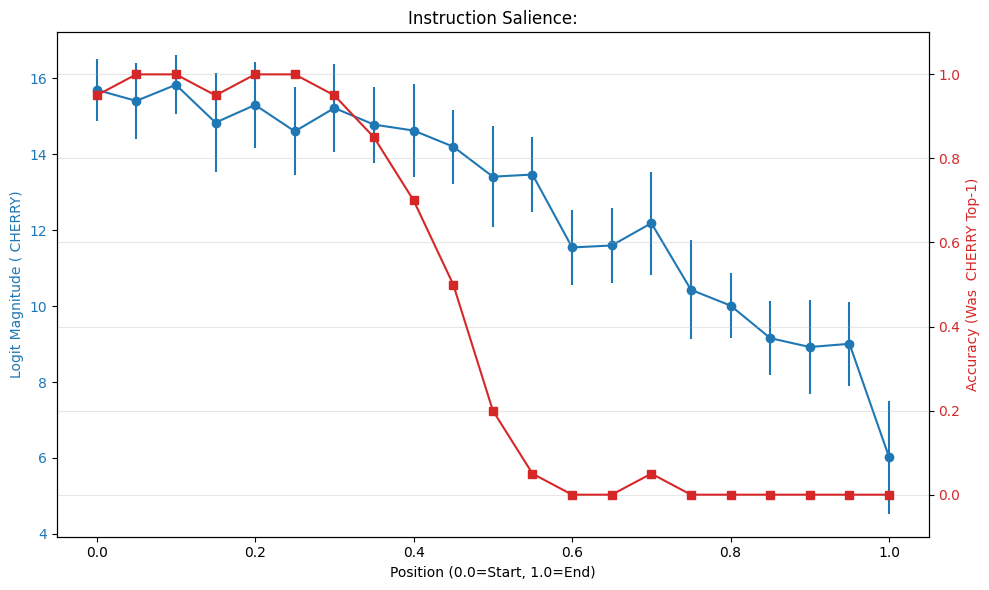

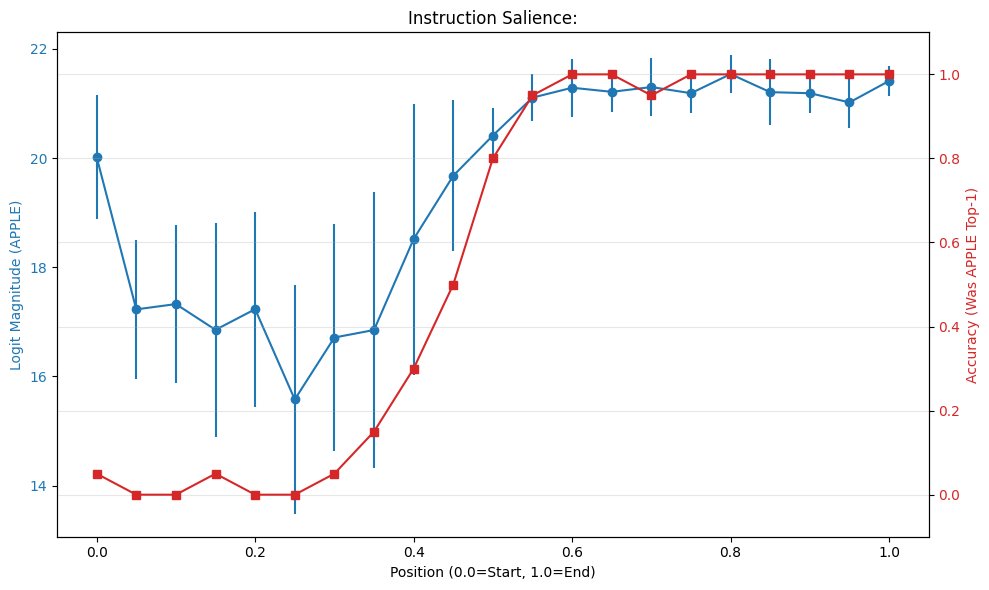

In [ ]:
print(sweep_data)
plot_dual_results(sweep_data, " CHERRY")
plot_dual_results(sweep_data, " APPLE")

In [38]:
id = tokenizer.encode("APPLE", add_special_tokens = False)
print(id)

[109248]


In [21]:
print(examples)

{0.0: ['CHERRY \n\n\n'], 0.05: ['CHERRY  Oldham is a large town in Greater Manchester, England.'], 0.1: ['CHERRY \n\n\n'], 0.15: ["CHERRY.  Berkley Warren Bedell's political career began"], 0.2: ['CHERRY  The story of Tales of Destiny 2 is a complex one'], 0.25: ['CHERRY  Fort Glanville Conservation Park is a protected area located in the'], 0.3: ["CHERRY  The game's narrative revolves around John Rook, a recently"], 0.35: ['CHERRY.  \n\nThe provided text details the history of the 7'], 0.4: ['CHERRY.  The 1955 Atlantic hurricane season was a'], 0.45: ['APPLE  The politics of Croatia are defined by a parliamentary, representative democratic republic'], 0.5: ['APPLE  \n\nThe provided text is a comprehensive overview of the politics of Croatia'], 0.55: ['APPLE-flavored candy is a popular treat enjoyed by people of all ages.'], 0.6: ['APPLE  McAllister Tower Apartments is a 28 @-@ story ,'], 0.65: ['APPLE.  The role of the stay-at-home dad has become'], 0.7: ['APPLE.  This is a fascinatin

In [21]:
import gc, torch
for name in ("trainer","model","optim","scheduler"):
    if name in globals(): del globals()[name]
gc.collect()
torch.cuda.empty_cache()